In [91]:
from matplotlib import pyplot as plt
import numpy as np
import networkx as nx
from running import rw_directory
from model.myGraph import MyGraph
from typing import Tuple
from model.utils import compute_laplacian_eigenxx, sinc
import seaborn as sns

import csv

import matplotlib.colors as mcolor
from model.synthetic_graph import build_circle_structure_split, fan


In [92]:
def show(P_lambda, title, vmin=-0.1, vmax=0.7, annot=True, is_save=False):
    """绘制矩阵热力图"""
    fig, ax = plt.subplots(figsize=(6, 4))
    # camp：颜色条名称；vmin, vmax：规定颜色的取值范围；annot：是否用数据标注矩阵格子
    sns.heatmap(P_lambda, cmap='coolwarm', ax=ax, vmin=vmin, vmax=vmax, annot=annot)

    xticks = np.arange(0, 100, 5)
    yticks = np.arange(0, 100, 5)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels([int(x) if x % 10 == 0 else "" for i, x in enumerate(xticks)])
    ax.set_yticklabels([int(y) if y % 10 == 0 else "" for i, y in enumerate(yticks)])

    # 显示图形
    plt.title(title)
    if is_save:
        plt.xticks(rotation=0)  # 立起来显示
        ax.set_xticklabels([int(x / 10) if x % 10 == 0 else "" for i, x in enumerate(xticks)])
        ax.set_yticklabels([int(y / 10) if y % 10 == 0 else "" for i, y in enumerate(yticks)])
        file_name = rw_directory.result_path(5, f"{title}.pdf")
        plt.savefig(file_name, bbox_inches='tight', pad_inches=0)
    plt.show()

In [93]:
def extend_matrix(A, x):
    """
    将小矩阵组合成大矩阵
    A：需扩充的矩阵
    x：扩充的维度
    """
    # 原始的 n*n 矩阵
    n = len(A)
    # 扩充后的 x*x 矩阵
    B = np.ones((x, x))
    # 构造全零大矩阵
    M = np.zeros((n * x, n * x))
    for i in range(n):
        for j in range(n):
            # 构造扩充后的小矩阵
            C = A[i][j] * B
            # 将小矩阵填入大矩阵中
            M[i * x:(i + 1) * x, j * x:(j + 1) * x] = C
    return M

In [94]:
def save_csv(matrix, file_name='matrix.csv'):
    with open(file_name, mode='w', newline='') as file:
        writer = csv.writer(file)
        for row in matrix:
            writer.writerow(row)
        file.close()

In [95]:
def combine(eigvals, P, n, time=0.2, annot=True, extend=1, graphName=''):
    """将所有 P_m 组合成大矩阵"""
    unique_lambda = np.unique(eigvals)  # 互异的特征值
    m = len(unique_lambda)
    M = [[0] * (m * n * extend) for i in range(m * n * extend)]
    M_time = [[0] * (m * n * extend) for i in range(m * n * extend)]
    for x, eval1 in enumerate(unique_lambda):
        print(eval1)
        i = 0
        sum_C = np.zeros((n, n))
        for y, eval2 in enumerate(unique_lambda):
            C = np.multiply(P[eval1], P[eval2])
            C = np.where(np.abs(C) < 0.000001, 0, C)  # 将较小的数值直接置为0
            sinc_ans = sinc(time * (eval1 - eval2))
            C1 = C * sinc_ans
            C1 = np.where(np.abs(C1) < 0.000001, 0, C1)  # 将较小的数值直接置为0
            sum_C = sum_C + C1

            i = i + 1
            if extend > 1:
                C = extend_matrix(C, extend)
                C1 = extend_matrix(C1, extend)
            for k in range(len(C)):
                for l in range(len(C[0])):
                    M[x * len(C) + k][y * len(C) + l] = C[k][l]
                    M_time[x * len(C) + k][y * len(C) + l] = C1[k][l]
    show(M, 'Time Parameter Ignored_' + graphName, vmin=-0.03, vmax=0.03, annot=False, is_save=True)
    show(M_time, 'time = ' + str(time) + '_'+graphName, vmin=-0.03, vmax=0.03, annot=False, is_save=True)
    file_name = rw_directory.result_path(5, f"combined_time_{time}_{graphName}.csv")
    save_csv(M_time, file_name)
    
    file_name = rw_directory.result_path(5, f"Time Parameter Ignored_{graphName}.csv")
    save_csv(M, file_name)
    # print(M_time.size)


In [96]:
def draw_constructed_graph(scale=1, k=None, graphName=''):
    """"""
    color_map = {}
    for color_name, color_val in mcolor.XKCD_COLORS.items():
        red = color_val.strip('#').upper()[0:2]
        green = color_val.strip('#').upper()[2:4]
        blue = color_val.strip('#').upper()[4:6]
        rgb = list(map(lambda x: int(x, base=16), [red, green, blue]))
        color_name = "XKCD-" + "-".join(color_name.strip(' ').split(':')[1].split(' '))
        color_map[color_name] = rgb
    color_map = list(color_map.keys())

    g, roles = build_circle_structure_split([[fan, 4], [fan, 3]], 1, 1)
    if graphName == "deleted":
        g.remove_edge(5,6)
        g.remove_edge(6,7)
    # graphName = "constructed"
    pos = nx.layout.kamada_kawai_layout(g, scale=scale)
    cur_color_map = {role: color_map[i] for i, role in enumerate(np.unique(roles))}
    node_color = {node: cur_color_map[roles[node]] for node in g.nodes}
    
    plt.grid(False)
    nx.draw_networkx(g, pos=pos,with_labels=False,node_color='navy')
    file_name = rw_directory.result_path(5, graphName + '.pdf')
    plt.savefig(file_name, bbox_inches='tight', pad_inches=0)
    return g

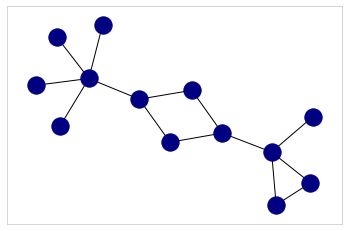

In [97]:
graphName = 'deleted'

# graphName = 'constructed'
g = draw_constructed_graph(graphName=graphName)


file_name = rw_directory.temp_file_path(5, graphName + 'edgelist')
with open(file_name, 'wb') as f:
    nx.write_edgelist(g, f)

# 计算特征向量
eigvals, eigvecs, index = compute_laplacian_eigenxx(g)
eigvecs = eigvecs[:, np.argsort(eigvals)]  # 特征向量按照特征值排序
eigvals = eigvals[np.argsort(eigvals)]

fname = rw_directory.temp_file_path(5, 'eigvals.csv')
save_csv(eigvals.reshape(-1, 1), fname)

fname = rw_directory.temp_file_path(5, 'eigvecs.csv')
save_csv(eigvecs, fname)

In [98]:
# 计算MultiHopAMKS
from model.AMKS.amks import AMKS

graph = MyGraph(g)
graph.set_graph_tag(graphName)
embed_model_one = AMKS()
T = 6
sigma = 2
step = 4

embed_model_one.set_g(g)
embed_model_one.set_time(T)
embed_model_one.set_sigma(sigma)
embed_model_one.set_step(step)
embed_model_one.compute_emb_vec()
graph_one_embed_vec = embed_model_one.get_embedding_vec(sorted(g.nodes))


In [99]:
# 计算投影矩阵
n = len(g.nodes)
k = 3  # 取第k个特征值
P = {}
for k in range(n):
    eigval = eigvals[k]
    eigvecs_k = eigvecs[:, eigvals == eigval]
    # eigvecs_k = eigvecs #[:, k]
    mu_lambda = sum(eigvals == eigval)  # 特征值重数
    P[eigval] = np.zeros((n, n))
    for i in range(mu_lambda):
        phi_lambda_k = eigvecs_k[:, i]
        P[eigval] += np.dot(phi_lambda_k.reshape(-1, 1), phi_lambda_k.reshape(1, -1))
    P[eigval] = np.where(np.abs(P[eigval]) < 0.000001, 0, P[eigval])  # 将较小的数值直接置为0

# 特征向量的平方
evec_P = np.power(eigvecs, 2)

# 经验证和对比得到的结论是
# 前提 特征值(0,1,1,1,5)
# 1. 这样计算投影矩阵的方法是正确的；
# 2. 有个特殊情况，对于第二、第三和第四个特征值都为1时，即重数为3。我们这里的计算方法是把这几个特征向量的投影矩阵相加，以加和后的矩阵作为特征值为1的投影矩阵。总共才有三个(0,1,5)的投影矩阵
#    但是在论文计算时，会保留特征值为1的所有这三个投影矩阵。然后再分别取五个投影矩阵(0,1,1,1,5)的对角线元素构成5*5的矩阵，每一列是投影矩阵的对角元素(特征向量元素的平方)。
#  也就是说，目前我们的方法是以不同特征值划分的，可以得到三个。论文中是以不同特征向量划分的，可以得到五个。重点是要理解投影矩阵！！

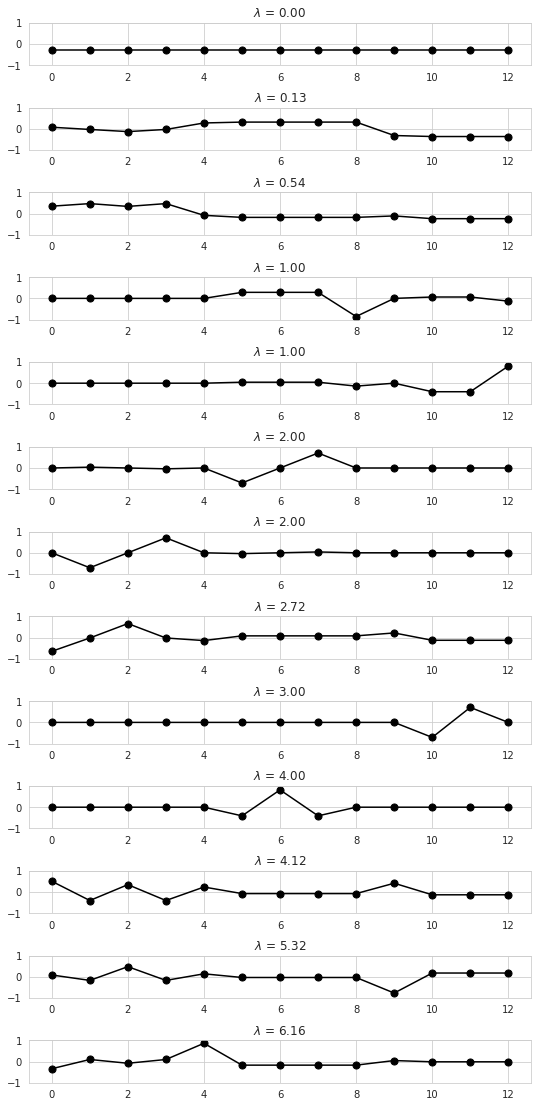

In [100]:
# 打印特征向量
e = eigvals
u = eigvecs
# selected_e = [0,2,6,9]
selected_e = range(n)
fig, axis = plt.subplots(nrows=len(selected_e), figsize=(9, len(selected_e) * 1.5))
for index, i in enumerate(selected_e):
    # axis[index].stem(range(g_size),u.T[i],linefmt='g', markerfmt='b')
    # axis[index].fill_between(range(g_size),u.T[i]-0.1, u.T[i]+0.1, color='blue', alpha=0.2)
    axis[index].scatter(range(n), u.T[i], s=50, c='black')
    axis[index].plot(range(n), u.T[i], c='black')
    axis[index].set_title(r"$\lambda$ = {:0.2f}".format(e[i]))
    axis[index].set_ylim(bottom=-1.0, top=1.0)

plt.subplots_adjust(hspace=1.0)
# plt.rcParams["axes.unicode_minus"] = False
file_name = rw_directory.result_path(5, "eigenvecs.pdf")
plt.savefig(file_name, bbox_inches='tight', pad_inches=0)

In [101]:
# 连通图特征向量元素和始终为1，故可以视为概率分布
temp = eigvecs[1]
temp1 = np.power(temp, 2)
temp2 = np.sum(temp1)

In [102]:
def mixing_matrix_calculation(eigvals, P, n, time=0.2):
    """计算混合矩阵"""
    unique_lambda = np.unique(eigvals)  # 互异的特征值
    max_value = -20
    min_value = 20

    for eval1 in unique_lambda:
        i = 0
        sum_C = np.zeros((n, n))
        for eval2 in unique_lambda:
            C = np.multiply(P[eval1], P[eval2])
            sinc_ans = sinc(time * (eval1 - eval2))
            C1 = C * sinc_ans
            sum_C = sum_C + C1
            max_value = np.max([np.amax(sum_C), max_value])
            min_value = np.min([np.amin(C1), min_value])
            i = i + 1

    M_hat = np.zeros((n, n))
    for eval1 in unique_lambda:
        print(eval1)
        # show(P[eval1],title = 'lamda'+str(eval1))
        # fig, axs = plt.subplots(nrows=len(unique_lambda), figsize=(6, 4*len(unique_lambda)))
        i = 0
        sum_C = np.zeros((n, n))
        for eval2 in unique_lambda:
            # 计算哈达吗积
            C = np.multiply(P[eval1], P[eval2])  # 不考虑时间
            sinc_ans = sinc(time * (eval1 - eval2))
            C1 = C * sinc_ans  # 考虑时间
            sum_C = sum_C + C1
            # sns.heatmap(C1, cmap='coolwarm', ax=axs[i], vmin = min_value, vmax = max_value, annot=annot)
            # axs[i].set_title('lamda'+str(eval1)+'*lamda'+str(eval2))
            i = i + 1
        # plt.show()
        # show(sum_C,'lamda'+str(eval1)+'_sum',vmin=min_value, vmax=max_value,annot=annot)
        M_hat = M_hat + sum_C  # ans_M 表示有限时间的平均混合核矩阵M_hat
    return M_hat



In [103]:
# 打印混合矩阵，然后验证节点间的平均跃迁概率被总结在平均混合核矩阵之中。即双随机矩阵。
time = 6
M_hat = mixing_matrix_calculation(eigvals, P, n=n, time=time)
ans_M1 = np.sum(M_hat, axis=0)  # 按行加和，验证节点之间的平均跃迁概率被总结在平均混合核中，这个概率与取时间多少无关
print(ans_M1)
ans_M2 = np.sum(M_hat, axis=1)  # 按列加和，验证
print(ans_M2)

1.649346366541833e-15
0.13070935812955137
0.5402074834971241
0.999999999999999
1.0
1.9999999999999982
1.9999999999999991
2.7247290750679083
3.0000000000000018
4.000000000000001
4.12329872483596
5.317423696981746
6.163631661487713
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


1.649346366541833e-15
0.13070935812955137
0.5402074834971241
0.999999999999999
1.0
1.9999999999999982
1.9999999999999991
2.7247290750679083
3.0000000000000018
4.000000000000001
4.12329872483596
5.317423696981746
6.163631661487713


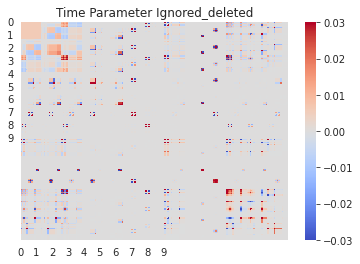

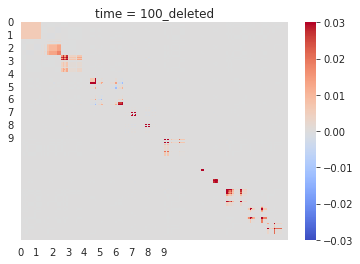

In [104]:
# 展示混合矩阵
time = 100
combine(eigvals, P, n=n, time=time, annot=True, extend=1, graphName=graphName)

In [105]:
def show_Projectors(eigvals, P):
    """展示P_lamda矩阵"""
    n = len(P)
    unique_lambda = np.unique(eigvals)  # 互异的特征值
    # 生成10个10*10的零矩阵
    matrices = [P[eval] for x, eval in enumerate(unique_lambda)]
    # 将10个矩阵按照对角线位置组成一个100*100的矩阵
    M = np.zeros((n * n, n * n))
    for i, matrix in enumerate(matrices):
        for j in range(n):
            for k in range(n):
                M[i * n + j, i * n + k] = matrix[j, k]
    show(M, "P_lambda_"+graphName, vmin=-0.4, vmax=0.4, annot=False, is_save=True)
    # 保存
    fname = rw_directory.result_path(5, 'P_lamda_' + graphName + '.csv')
    save_csv(M, fname)

    return M

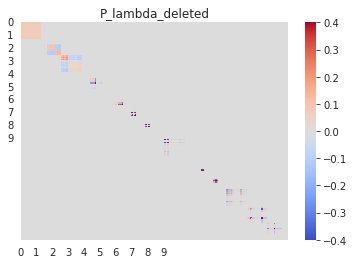

In [106]:
# 显示投影矩阵，比较四次幂和平方
Projectors = show_Projectors(eigvals, P)

In [107]:
def show_Pm(eigvals, P):
    """展示P_m矩阵"""
    n = len(P)
    unique_lambda = np.unique(eigvals)  # 互异的特征值
    #
    Pm = {}
    for y, eval2 in enumerate(sorted(unique_lambda)):
        # 计算哈达吗积
        Pm[eval2] = np.multiply(P[eval2], P[eval2])
        Pm[eval2] = np.where(np.abs(Pm[eval2]) < 0.000001, 0, Pm[eval2])  # 将较小的数值直接置为0

    # 生成10个10*10的零矩阵
    matrices = [Pm[eval] for x, eval in enumerate(unique_lambda)]
    # 将10个矩阵按照对角线位置组成一个100*100的矩阵
    M = np.zeros((n * n, n * n))
    for i, matrix in enumerate(matrices):
        for j in range(n):
            for k in range(n):
                M[i * n + j, i * n + k] = matrix[j, k]
    show(M, "Pm_"+graphName, vmin=-0.15, vmax=0.15, annot=False, is_save=True)
    # 保存
    fname = rw_directory.result_path(5, 'Pm_' + graphName + '.csv')
    save_csv(M, fname)

    return M

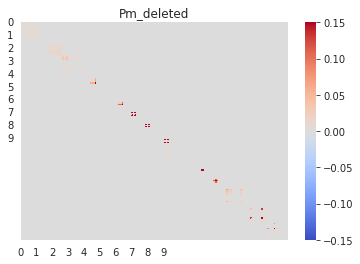

array([[0.00591716, 0.00591716, 0.00591716, ..., 0.        , 0.        ,
        0.        ],
       [0.00591716, 0.00591716, 0.00591716, ..., 0.        , 0.        ,
        0.        ],
       [0.00591716, 0.00591716, 0.00591716, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [108]:
show_Pm(eigvals, P)